In [1]:
import sqlite3
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import math

db_path = "city_infections2.db"
covid_paths = "../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_"

conn = sqlite3.connect(db_path)
c = conn.cursor()
c2 = conn.cursor()

c.execute('PRAGMA foreign_keys = ON')
c2.execute('PRAGMA foreign_keys = ON')

In [92]:
# Create tables
create_locations_table_command = '''
CREATE TABLE IF NOT EXISTS locations (
    country VARCHAR(255),    
    city VARCHAR(255),
    location VARCHAR(255) NOT NULL,
    date DATE NOT NULL,
    susceptible INT,
    infected INT,
    delta_infected FLOAT,
    recovered INT,
    deaths INT,
    PRIMARY KEY(date, location)
    );
'''
c.execute(create_locations_table_command)
conn.commit()

In [2]:
confirmed_file = covid_paths + 'confirmed_global.csv'
deaths_file = covid_paths + 'deaths_global.csv'
recovered_file = covid_paths + 'recovered_global.csv'
df_confirmed = pd.read_csv(confirmed_file)
df_deaths = pd.read_csv(deaths_file)
df_recovered = pd.read_csv(recovered_file)

print(df_confirmed.head())

  Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  3/20/20  3/21/20  3/22/20  3/23/20  \
0        0        0        0  ...       24       24       40       40   
1        0        0        0  ...       70       76       89      104   
2        0        0        0  ...       90      139      201      230   
3        0        0        0  ...       75       88      113      133   
4        0        0        0  ...        1        2        2        3   

   3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  3/29/20  
0       74       84   

In [3]:
print(df_recovered.loc[df_recovered['Province/State'] == 'New Brunswick'])

Empty DataFrame
Columns: [Province/State, Country/Region, Lat, Long, 1/22/20, 1/23/20, 1/24/20, 1/25/20, 1/26/20, 1/27/20, 1/28/20, 1/29/20, 1/30/20, 1/31/20, 2/1/20, 2/2/20, 2/3/20, 2/4/20, 2/5/20, 2/6/20, 2/7/20, 2/8/20, 2/9/20, 2/10/20, 2/11/20, 2/12/20, 2/13/20, 2/14/20, 2/15/20, 2/16/20, 2/17/20, 2/18/20, 2/19/20, 2/20/20, 2/21/20, 2/22/20, 2/23/20, 2/24/20, 2/25/20, 2/26/20, 2/27/20, 2/28/20, 2/29/20, 3/1/20, 3/2/20, 3/3/20, 3/4/20, 3/5/20, 3/6/20, 3/7/20, 3/8/20, 3/9/20, 3/10/20, 3/11/20, 3/12/20, 3/13/20, 3/14/20, 3/15/20, 3/16/20, 3/17/20, 3/18/20, 3/19/20, 3/20/20, 3/21/20, 3/22/20, 3/23/20, 3/24/20, 3/25/20, 3/26/20, 3/27/20, 3/28/20, 3/29/20]
Index: []

[0 rows x 72 columns]


In [5]:
dates = []
for col in df_confirmed.columns:
    pattern = re.compile('^\d+/\d+/\d+')
    if pattern.match(col):
        dates.append(col)

significant_locations = []
        
for row in df_confirmed.iterrows():
    city = row[1]['Province/State']
    country = row[1]['Country/Region']
    join_col = 'Province/State'
    join_val = city
    
    if country == 'Canada':
        continue
    
    if pd.isnull(row[1]['Province/State']):
        join_col = 'Country/Region'
        join_val = country
    
    deaths_row = df_deaths.loc[df_deaths[join_col] == join_val]
    recovered_row = df_recovered.loc[df_recovered[join_col] == join_val]
        
    location = country
    if (isinstance(city, str)):
         location = location + ', ' + city

    prev_confirmed = -1
    prev_prev_confirmed = -1
    prev_deaths = -1
    prev_recovered = -1
    prev_date = ""
    prev_date_str = ""
    count = 0
    start_counting = False
    for date in dates:
        split_date = date.split('/')
        month = split_date[0].zfill(2)
        day = split_date[1].zfill(2)
        year = '20' + split_date[2]
        date_str = year + '-' + month + '-' + day
        
        cur_confirmed = row[1][date]
        
        if cur_confirmed > 0 or start_counting:
            count += 1
            start_counting = True
        
        if prev_confirmed == -1:
            prev_confirmed = cur_confirmed
            prev_date = date
            prev_date_str = date_str
            continue
            
        if prev_prev_confirmed == -1:
            prev_prev_confirmed = prev_confirmed
            prev_confirmed = cur_confirmed
            prev_date = date
            prev_date_str = date_str
            continue
        
        delta_confirmed = (cur_confirmed - prev_prev_confirmed) / 2
        
        
        if prev_date is not "":
            prev_deaths = deaths_row.iloc[0][prev_date]
            prev_recovered = recovered_row.iloc[0][prev_date]
            prev_infected = prev_confirmed - prev_deaths - prev_recovered
            
            c.execute('INSERT INTO locations (country, city, location, date, infected, delta_infected, recovered, deaths) VALUES (\
                      "'+str(country)+'",\
                      "'+str(city)+'",\
                      "'+str(location)+'",\
                      "'+str(prev_date_str)+'",\
                      "'+str(prev_infected)+'",\
                      "'+str(delta_confirmed)+'",\
                      "'+str(prev_recovered)+'",\
                      "'+str(prev_deaths)+'"\
                     );')
            
        
        prev_prev_confirmed = prev_confirmed
        prev_confirmed = cur_confirmed
        prev_date = date
        prev_date_str = date_str
        
    if count > 50:
        significant_locations.append(location)

print(significant_locations)
conn.commit()
        

['Australia, New South Wales', 'Australia, Queensland', 'Australia, South Australia', 'Australia, Victoria', 'Belgium', 'Cambodia', 'China, Anhui', 'China, Beijing', 'China, Chongqing', 'China, Fujian', 'China, Gansu', 'China, Guangdong', 'China, Guangxi', 'China, Guizhou', 'China, Hainan', 'China, Hebei', 'China, Heilongjiang', 'China, Henan', 'China, Hong Kong', 'China, Hubei', 'China, Hunan', 'China, Inner Mongolia', 'China, Jiangsu', 'China, Jiangxi', 'China, Jilin', 'China, Liaoning', 'China, Macau', 'China, Ningxia', 'China, Qinghai', 'China, Shaanxi', 'China, Shandong', 'China, Shanghai', 'China, Shanxi', 'China, Sichuan', 'China, Tianjin', 'China, Tibet', 'China, Xinjiang', 'China, Yunnan', 'China, Zhejiang', 'Diamond Princess', 'Finland', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Korea, South', 'Malaysia', 'Nepal', 'Philippines', 'Russia', 'Singapore', 'Spain', 'Sri Lanka', 'Sweden', 'Taiwan*', 'Thailand', 'United Arab Emirates', 'United Kingdom', 'US', 'Vietnam']


In [38]:
c.execute('SELECT location, susceptible FROM locations;')

#print(significant_locations)

has_issue = set()

for row in c:
    if row[1] is None and row[0] in significant_locations:
        has_issue.add(row[0])
for i in has_issue:
    print(i)

In [24]:
conn_population = sqlite3.connect('population.db')
pop_c = conn_population.cursor()

In [36]:
c.execute('UPDATE locations SET country="Taiwan" WHERE location="Taiwan";')
significant_locations[significant_locations.index('Taiwan*')] = 'Taiwan'

c.execute('UPDATE locations SET country="South Korea" WHERE location="South Korea";')
significant_locations[significant_locations.index('Korea, South')] = 'South Korea'

significant_locations.remove('Diamond Princess')

c.execute('UPDATE locations SET country="UK" WHERE location="UK";')
significant_locations[significant_locations.index('United Kingdom')] = 'UK'

pop_c.execute('UPDATE australia SET city="Australia, Queensland" WHERE city="Queensland";')
pop_c.execute('UPDATE australia SET city="Australia, Victoria" WHERE city="Victoria";')
pop_c.execute('UPDATE australia SET city="Australia, South Australia" WHERE city="South Australia";')

conn_population.commit()
conn.commit()

In [37]:
pop_c.execute('SELECT province, population_2018 FROM china_provinces;')
for row in pop_c:
    province = row[0]
    population = row[1]
    c.execute('SELECT date, infected, recovered, deaths FROM locations WHERE city="'+province+'"')
    for entry in c:
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        deaths = entry[3]
        susceptible = population - infected - recovered - deaths
        c2.execute('UPDATE locations SET susceptible="'+str(susceptible)+'" WHERE city="'+province+'" AND date="'+date+'"')
conn.commit()    

'''
pop_c.execute('SELECT abb, population_2020 FROM usa;')
for row in pop_c:
    state = row[0]
    population = row[1]
    c.execute('SELECT date, infected, recovered FROM locations WHERE SUBSTR(city, LENGTH(city) - 1, 2) LIKE "'+state+'";')
    for entry in c:
        
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        deaths = entry[3]
        susceptible = population - infected - recovered - deaths
        c2.execute('UPDATE cities SET susceptible="'+str(susceptible)+'" WHERE SUBSTR(city, LENGTH(city) - 1, 2) LIKE "'+state+'" AND date="'+date+'"')
conn.commit()    
'''

pop_c.execute('SELECT * FROM canada;')
for row in pop_c:
    city = ' '+row[0]
    population = row[1]
    length = len(city)
    c.execute('SELECT date, infected, recovered, deaths FROM locations WHERE SUBSTR(city, 1, '+str(length)+') LIKE "'+city+'";')
    for entry in c:
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        deaths = entry[3]
        susceptible = population - infected - recovered - deaths
        c2.execute('UPDATE locations SET susceptible="'+str(susceptible)+'" WHERE SUBSTR(city, 1, '+str(length)+') LIKE "'+city+'" AND date="'+date+'"')
conn.commit()    

pop_c.execute('SELECT * FROM country_populations;')
for row in pop_c:
    country = row[0]
    population = int(str(row[1]).replace(' ', ''))*1000
    if 'China' in country or country == 'Canada' or country == 'Australia':
        continue
    c.execute('SELECT date, infected, recovered, deaths FROM locations WHERE country="'+country+'"')
    for entry in c:
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        deaths = entry[3]
        susceptible = population - infected - recovered - deaths
        c2.execute('UPDATE locations SET susceptible="'+str(susceptible)+'" WHERE country="'+country+'" AND date="'+date+'"')
conn.commit()    

pop_c.execute('SELECT * FROM australia;')
for row in pop_c:
    location = row[0]
    population = row[1]
    c.execute('SELECT date, infected, recovered, deaths FROM locations WHERE location="'+location+'";')
    for entry in c:
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        deaths = entry[3]
        susceptible = population - infected - recovered - deaths
        c2.execute('UPDATE locations SET susceptible="'+str(susceptible)+'" WHERE location="'+location+'" AND date="'+date+'"')
conn.commit()    

In [39]:
all_locations = set()
c.execute('SELECT distinct location FROM locations;')

for row in c:
    all_locations.add(row[0])

for location in all_locations:
    if location not in significant_locations:
        c2.execute('DELETE FROM locations WHERE location="'+location+'";')
conn.commit()

In [58]:
c.execute('SELECT location FROM locations;')

included = set()

for row in c:
    included.add(row[0])

print(len(significant_locations), len(included))

59 59


In [ ]:
ori_conn = sqlite3.connect('city_infections.db')
ori_c = ori_conn.cursor()
ori_c.execute('PRAGMA foreign_keys = ON')

# Create tables
create_cities_table_command = '''
CREATE TABLE IF NOT EXISTS cities (
    country VARCHAR(255),    
    city VARCHAR(255),
    location VARCHAR(255) NOT NULL,
    date DATE NOT NULL,
    susceptible INT,
    infected INT,
    delta_infected FLOAT,
    recovered INT,
    deaths INT,
    PRIMARY KEY(date, location)
    );
'''
ori_c.execute(create_cities_table_command)
ori_conn.commit()

c.execute('SELECT * FROM locations;')

sql = "INSERT INTO cities (country, city, location, date, susceptible, infected, delta_infected, recovered, deaths) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)"

for row in c:
    val = (row)
    ori_c.execute(sql, val)
    
ori_conn.commit()

118380


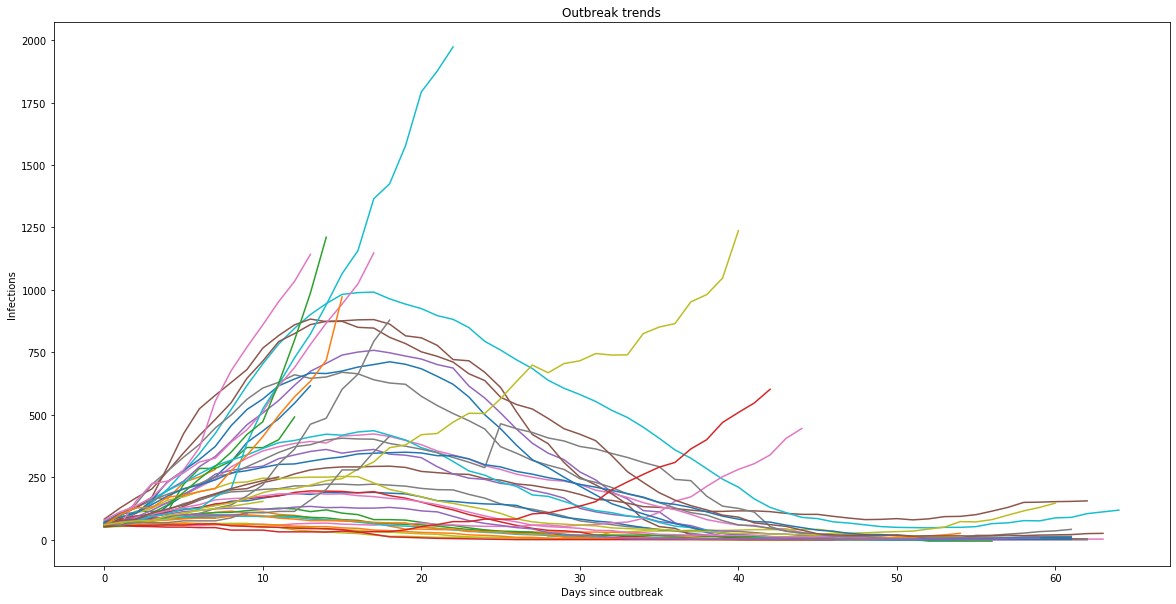

In [62]:
plt.figure(figsize=(20, 10))
plt.title("Outbreak trends")
plt.xlabel("Days since outbreak")
plt.ylabel("Infections")

maxxx = 0

for location in significant_locations:
    
    X = []
    Y = []
    start = False
    counter = 0
    include = True
    max_y = 0
    
    c2.execute('SELECT infected FROM locations WHERE location="'+location+'";')
    for entry in c2:
        if entry[0] > 2000:
            #print(location)
            include = False
        if entry[0] > 50:
            start = True
        if start != True:
            continue
        X.append(counter)
        counter += 1
        Y.append(entry[0])
        max_y = max(max_y, entry[0])
        maxxx = max(maxxx, entry[0])

        
    # Plot and show
    if include == True:
        plt.plot(X, Y)

print(maxxx)
plt.show()

conn.commit()

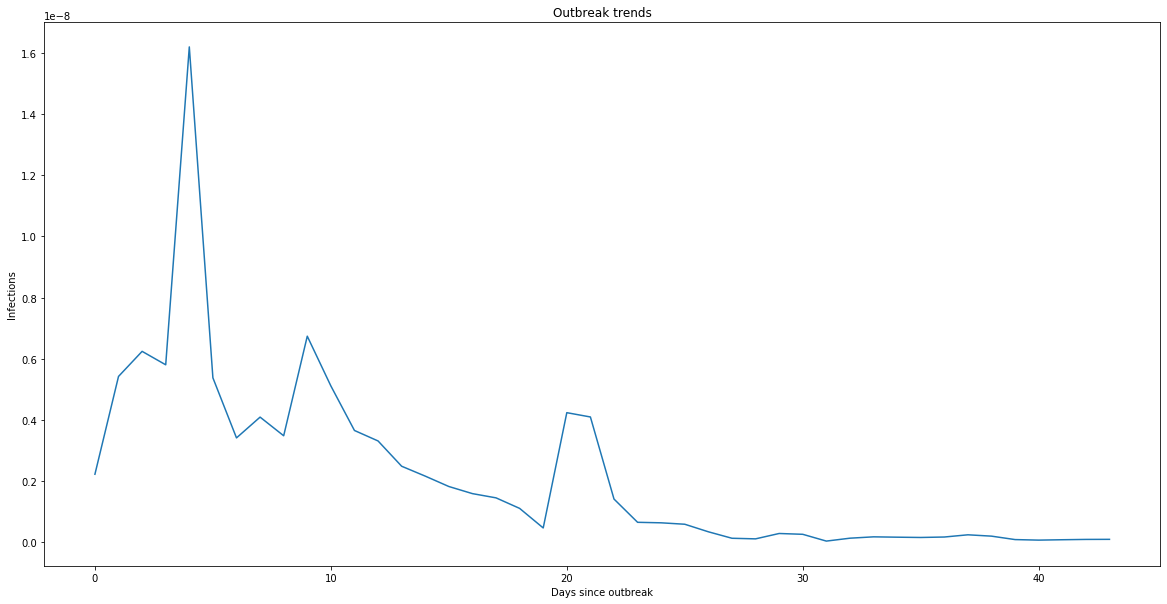

In [7]:
plt.figure(figsize=(20, 10))
plt.title("Outbreak trends")
plt.xlabel("Days since outbreak")
plt.ylabel("Infections")

maxxx = 0

target = "Mainland China, Hubei"

c2.execute('SELECT infected, susceptible, delta_infected FROM cities WHERE location="'+target+'";')

counter = 0

X = []
Y = []
for entry in c2:
    X.append(counter)
    counter += 1
    Y.append(entry[2] / entry[1] / entry[0])
plt.plot(X, Y)
plt.show()


THISSS,  Mainland China, Beijing
THISSS,  Mainland China, Beijing
THISSS,  Mainland China, Guangdong
THISSS,  Mainland China, Hubei
THISSS,  Mainland China, Hubei
THISSS,  Mainland China, Hubei
Japan


TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

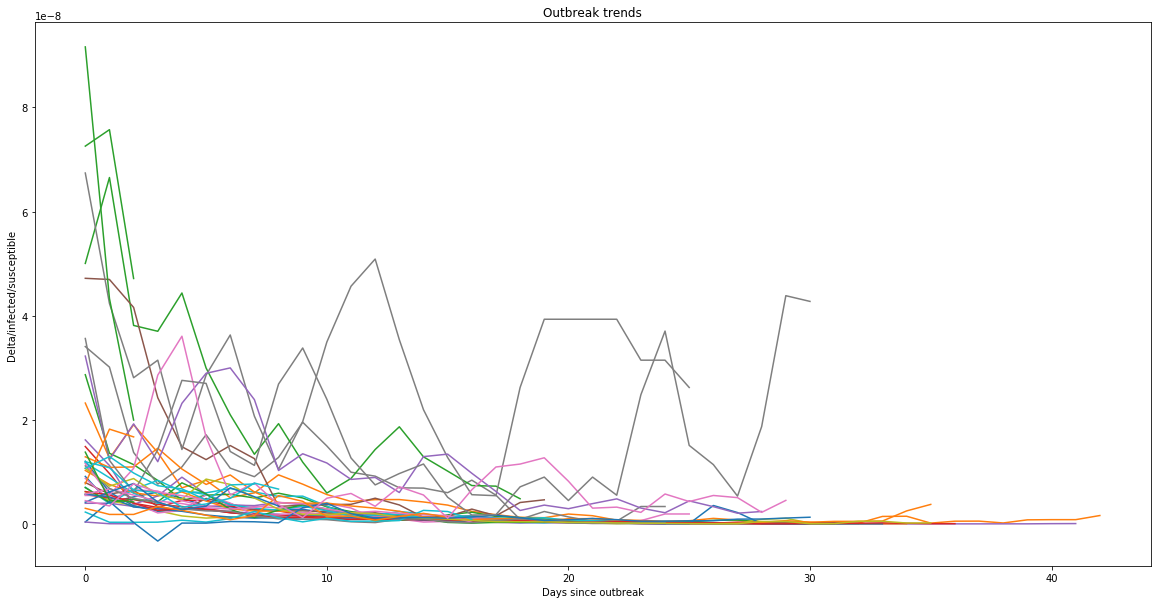

In [30]:
plt.figure(figsize=(20, 10))
plt.title("Outbreak trends")
plt.xlabel("Days since outbreak")
plt.ylabel("Delta/infected/susceptible")

maxxx = 0

for row in df_recovered.iterrows():
    city = row[1]['Province/State']
    country = row[1]['Country/Region']
    location = country
    if (isinstance(city, str)):
         location = location + ', ' + city
    
    X = []
    Y = []
    start = False
    counter = 0
    include = True
    max_y = 0
    
    c2.execute('SELECT infected, susceptible, delta_infected FROM cities WHERE location="'+location+'";')

    for entry in c2:
        if entry[0] > 2000:
            include = False
        if entry[0] > 20:
            start = True
        if start != True:
            continue
        if entry[2] < 0:
            print(location)
        if entry[2] == 0:
            continue
        y = entry[2] / entry[1] / entry[0]
        if y > 1 * 1e-7:
            #print(location)
            include = False
        if counter > 40:
            print("THISSS, ", location)
        X.append(counter)
        counter += 1
        Y.append(y)

        
    # Plot and show
    if include == True:
        plt.plot(X, Y)

plt.show()
